<img src="figuras/mbit-logo.png" align="right" style="float" width="200">
<font color="#CA3532"><h1 align="left">Clustering</h1></font>
<h2 align="left">Base de datos sintética. DBSCAN</h2>

Primero importamos las librerías que necesitaremos. También activaremos el modo *inline* para los gráficos generados por *matplotlib*. También inicializaremos la semilla del generador de números aleatorios.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_moons, make_circles
from numpy import linalg
from matplotlib.patches import Ellipse

Ahora crearemos un problema no supervisado sintético. El objetivo es entender los conceptos principales con este prolema, luego analizaremos bases de datos reales. Usaremos la función "make_blobs" que genera datos con un número especificado de "blobs". Esta función escoge aleatoriamente los centros de los blobs.

Los parámetros que cambiaremos se comentan aquí:

## Funciones para crear y dibujar los datos en el problema de los clusters elipsoidales

In [2]:
def rota_datos_alrededor_origen(X, angulo):
    angle_rad = angulo*2.0*np.pi/360.0

    s = np.sin(angle_rad)
    c = np.cos(angle_rad)
    matriz_rotacion = np.array([[c,-s],[s,c]])
    X_rotados = np.dot(matriz_rotacion, X) # se rotan los puntos generados

    return X_rotados

def genera_puntos_gaussiana2D(Npuntos, media, std1, std2, angulo):
    X = np.random.randn(2, Npuntos)
    X[0,:] = X[0,:] * std1 # se multiplica cada atributo por la
    X[1,:] = X[1,:] * std2 # desviación estándar deseada
    X = rota_datos_alrededor_origen(X, angulo)
    X[0,:] = media[0] + X[0,:]
    X[1,:] = media[1] + X[1,:]

    return X.T

def genera_puntos_disco2D(Npuntos, media, radio):
    radios  = radio*np.sqrt(np.random.rand(Npuntos))
    angulos = (2*np.pi)*np.random.rand(Npuntos)
    X = np.zeros((Npuntos,2))
    X[:,0] = media[0] + radios*np.cos(angulos)
    X[:,1] = media[1] + radios*np.sin(angulos)
    return X

def plot_ellipsoid(mean, cov, color, splot, alpha=0.5):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    ell = Ellipse(mean, v[0]*2, v[1]*2, 180 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(alpha)
    splot.add_artist(ell)

def plot_ellipsoid_from_data(X, color, splot, alpha=0.5):
    plot_ellipsoid(np.mean(X.T, axis=1), np.cov(X.T), color, splot, alpha)

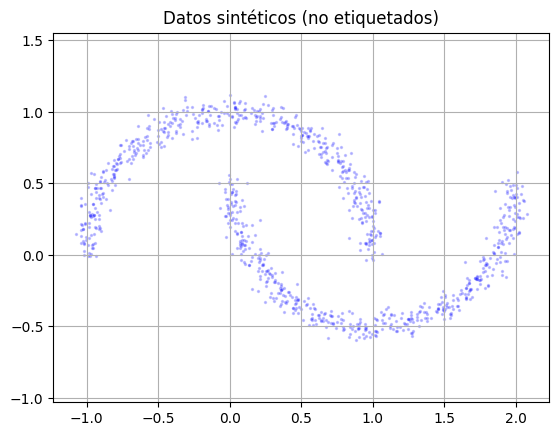

In [3]:
problema = 3

if problema==1:
    Nblobs = 3 # número de "blobs"
    X, y = make_blobs(random_state = 21,  # si cambiamos este parámetro cambiarán los "blobs" de ubicación
                      n_samples = 1000,   # número de puntos que serán generados en la base de datos
                      n_features = 2,     # número de dimensiones
                      centers = Nblobs,   # número de "blobs" (nubes)
                      cluster_std = 0.75) # ancho de cada "blob"

elif problema==2: # blobs de diferente tamanyo
    Nblobs = 3
    stds = [1, 3, 1]
    X, y = make_blobs(random_state = 21,  # si cambiamos este parámetro cambiarán los "blobs" de ubicación
                      n_samples = 1000,   # número de puntos que serán generados en la base de datos
                      n_features = 2,     # número de dimensiones
                      centers = Nblobs,   # número de "blobs" (nubes)
                      cluster_std = stds) # ancho de cada "blob"

elif problema==3: # dos "lunas" acopladas
    X = make_moons(n_samples=1000, noise=.05, random_state=21)[0]

elif problema==4: # circulo dentro de un circulo
    X = make_circles(n_samples=2000, factor=0.5, noise=.05, random_state=21)[0]

elif problema==5: # "Mickey Mouse"
    n_samples = 1000
    X1 = genera_puntos_disco2D(n_samples, [0, 5], 2)
    X2 = genera_puntos_disco2D(n_samples, [10, 5], 2)
    X3 = genera_puntos_disco2D(int(5*5/2/2*n_samples), [5, 0], 5)
    Xs = (X1, X2, X3)
    X = np.concatenate(Xs)

elif problema==6:
    n_samples = 1000
    #np.random.seed(0)
    X1 = genera_puntos_gaussiana2D(n_samples, [0, 0], 1, 1, 45)
    X2 = genera_puntos_gaussiana2D(n_samples, [10, 0], 3.5, 1, 45)
    X3 = genera_puntos_gaussiana2D(n_samples, [5, 5], 2, 1, 45)
    Xs = (X1, X2, X3)
    X = np.concatenate(Xs)
    colors = ['lightgreen', 'orange', 'yellow', 'magenta', 'lightblue']
    markers = ['s', 'v', 'o', 'd', 's']


    plt.figure(figsize=(6,6))
    splot = plt.subplot(1, 1, 1)
    for Xi,color in zip(Xs,colors):
        plot_ellipsoid_from_data(Xi, 'b', splot, alpha=0.2)

plt.scatter(X[:,0], X[:,1], color = 'b', s=2, alpha=0.2)
plt.grid()
plt.axis('equal')
plt.title('Datos sintéticos (no etiquetados)');

Demo interactiva: https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/

Hiperparámetros más importantes:

- **eps:** distancia máxima entre dos puntos para considerarse que uno está en el entorno del otro (uno es "vecino" del otro)

- **min_samples:** número de puntos (o peso total) que tiene que tener un punto en su entorno (incluido él mismo) para ser considerado como un punto core. Por otra parte, si el punto tiene al menos min_samples vecinos (incluido él mismo) y estos no están aún etiquetados con ningún cluster, propaga a ellos la etiqueta de cluster.

Cabe la posibilidad de que haya puntos que se queden aislados, no pertenezcan a ningún cluster. Se les asigna una etiqueta especial, -1, indicando que son outliers.

In [17]:
# sklearn.cluster.dbscan(X, eps=0.5, min_samples=5, metric=’minkowski’,
#                        metric_params=None, algorithm=’auto’, leaf_size=30,
#                        p=2, sample_weight=None, n_jobs=1)

dbscan = DBSCAN(min_samples=10, eps=0.1)
dbscan.fit(X)

DBSCAN(eps=0.1, min_samples=10)

In [18]:
Nclusters = len(np.unique(dbscan.labels_[dbscan.labels_!=-1]))
Nclusters

2

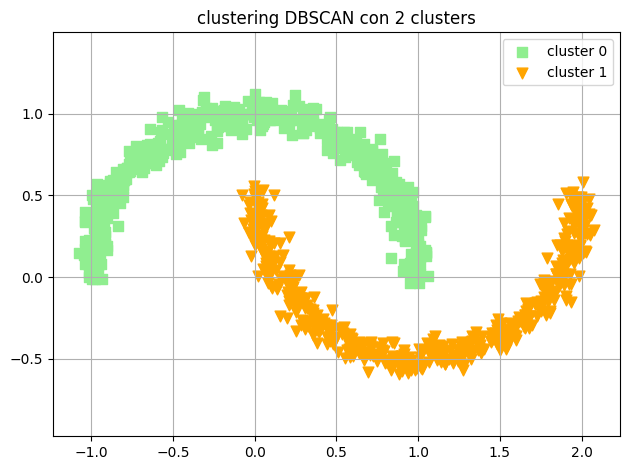

In [19]:
ax = plt.subplot(1,1,1)
colors = ['lightgreen', 'orange', 'yellow', 'magenta', 'lightblue']
markers = ['s', 'v', 'o', 'd', 's']
colors = 10*colors
markers = 10*markers

for i in range(Nclusters):
    plt.scatter(X[dbscan.labels_ == i, 0],
                X[dbscan.labels_ == i, 1],
                s = 60, c = colors[i], marker = markers[i],
                label = 'cluster %d' % (i))

plt.legend()
plt.grid()
plt.axis('equal')
plt.title(f'clustering DBSCAN con {Nclusters} clusters')
plt.tight_layout();

In [20]:
dbscan.labels_[:10]

array([0, 0, 1, 1, 1, 1, 0, 0, 1, 0])